In [46]:
### Imports

import os
import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, Sampler
from torchvision import transforms, utils
import torch.nn as nn

import tensorflow as tf
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, TensorDataset, DataLoader
from typing import Iterator, Callable, List, Tuple
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
import collections
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, r2_score

In [2]:
random.seed(7757)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
read_data = pd.read_csv(
    "/content/drive/MyDrive/NLP3/train.csv")


In [8]:
read_data

,id,title,content,class
0,0,PSD în alertă,Prăbușirea PSD de la altitudinea sigură a celo...,True
1,1,"În amintirea Vioricăi, milioane de români beau...",Moțiunea de cenzură care a doborât guvernul Dă...,True
2,2,"Dramă! Când credea că nu se poate mai rău, un ...",Credeai că ai ajuns la fundul sacului? Înseamn...,True
3,3,"Spania - România, 5-0. „Tricolorii”, îngenunch...","Echipa națională a României a fost umilită, lu...",False
4,4,"Campanie electorală, veselie generală","Toate cresc în campania electorală, cît n-au c...",True
...,...,...,...,...
70570,70570,Spații de cazare la mare înălțime. Refugiul Ie...,"Pentru drumeția de azi, un echipaj de interven...",True
70571,70571,"Sfântul Vali, colanții de la mall și miorița n...",Pe Mădălin nu l-a lăsat tac-su să termine opt ...,True
70572,70572,"Banii sănătății unde e, banii sănătății ce-ați...","Reforma sănătății a început, în România, pe vr...",True
70573,70573,Pentru că nu poate da o lege să nu mai bată vâ...,"Premierul Mihai Tudose a fost, din nou, deranj...",True


In [22]:
read_data["content"][2136]

'!>? Noi veşti de la Institutul Român de Studiere a Limbii Române. După o minuţioasă cercetare a mai multor texte s-a descoperit că semnul exclamării ridică mai multe semne de întrebare decît semnul întrebării. „?“ este folosit întotdeauna corect, însă „!“ apare unde te aştepţi mai puţin. De unde soare iepurele O reţea de schimbători de bancnote aniversare a fost anihilată de poliţiştii timişoreni. Infractorii colecţionau bancnote cu eclipsa de 2.000 de lei vechi pe care le transportau în Germania şi le schimbau în euro ca şi cum ar fi lei noi. O singură bancnotă cu eclipsa era schimbată cu o hîrtie de 500 de euro la mai multe case de schimb valutar germane afiliate reţelei. Acestea le revindeau apoi la preţ dublu turiştilor creduli. Luceafărul s-a prelungit Au mai fost descoperite încă patru strofe din „Luceafărul“, căzute în spatele unui sertar din scrinul poetului. Criticii au susţinut, pe bună dreptate, că „Luceafărul“ trebuia să aibă mai multe strofe, însă ele n-au fost de găsit p

In [5]:

print(len(read_data))
X = []
y = []

for i, row in read_data.iterrows():
  X.append([row['title'], row['content']])
  if(row['class'] == True):
    y.append(1)
  elif (row['class'] == False):
    y.append(0)



70575


Pregatirea datelor:
- Scoatem spatii multiple
- Url, email?
- greseli gramaticale?
- non-utf8
- procente?

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [46]:
num_features = 2

In [ ]:
num_features

12

In [ ]:
y_test.shape

torch.Size([714])

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print("device = ", device)

device =  cpu


In [10]:
BATCH_SIZE=64

In [9]:
df_train = {}
df_test = {}
df_train['title'] = []
df_train['content'] = []
df_train['class'] = []
df_test['title'] = []
df_test['content'] = []
df_test['class'] = []

for i in range(len(X_train)):
  df_train['title'].append(X_train[i][0])
  df_train['content'].append(X_train[i][1])
  df_train['class'].append(y_train[i])

for i in range(len(X_test)):
  df_test['title'].append(X_test[i][0])
  df_test['content'].append(X_test[i][1])
  df_test['class'].append(y_test[i])

print(len(df_train['title']), len(df_test))

56460 3


In [ ]:
(df_test['title'])

In [54]:
#Sursa: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1")

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [label for label in df['class']]
        self.titles = [tokenizer(str(text),
                                 padding='max_length', max_length = 128, truncation=True,
                                return_tensors="pt") for text in df['title']]
        self.contents = [tokenizer(str(text),
                                   padding='max_length', max_length = 1024, truncation=True,
                                return_tensors="pt") for text in df['content']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_title(self, idx):
        # Fetch a batch of inputs
        return self.titles[idx]

    def get_batch_content(self, idx):
        return self.contents[idx]

    def __getitem__(self, idx):

        batch_title = self.get_batch_title(idx)
        batch_content = self.get_batch_content(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_title, batch_content, batch_y

In [12]:
train_dataset = Dataset(df_train)

In [13]:
validation_dataset = Dataset(df_test)

In [14]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

In [15]:
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

In [16]:
class SatireClassifier(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size_1: int,
                 hidden_size_2: int,
                 hidden_size_3: int,
                 device: torch.device,
                 activation_fn: Callable,
                 dropout_rate: float):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_size_3 = hidden_size_3
        self.hidden_layer_1 = nn.Linear(input_size, hidden_size_1)
        self.hidden_layer_2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.hidden_layer_3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.output_layer = nn.Linear(hidden_size_2, 1) ####### Nu fi proasta si modifica
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(p=dropout_rate)
        self.device = device

    def forward(self, x):
        x = x.to(torch.float32)

        h1 = self.activation_fn(self.hidden_layer_1(x))
        h2 = self.activation_fn(self.hidden_layer_2(h1))
        #h3 = self.activation_fn(self.hidden_layer_3(h2))
        #h = self.activation_fn(self.dropout(self.hidden_layer(x)))
        out = self.output_layer(h2)

        return out

In [37]:
model = SatireClassifier(
    input_size=128,
    hidden_size_1=256,
    hidden_size_2=512,
    hidden_size_3=512,
    device=device,
    activation_fn=nn.ReLU(),
    dropout_rate=0.2
)
#model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
for param in model. parameters ():
  print(param)

In [18]:
loss_crt = nn.BCEWithLogitsLoss(

)

In [38]:
pos_weight = torch.tensor([1, 3])
loss_crct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [ ]:
loss_crt = nn.CrossEntropyLoss()

In [39]:
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

NUM_EPOCHS = 20

for epoch_idx in range(NUM_EPOCHS):
    train_labels = []
    val_labels = []
    train_preds = []
    val_preds = []

    train_epoch_loss = 0.0
    model.train()
    for batch_titles, batch_content, batch_labels in tqdm(train_dataloader):
        model.zero_grad()

        tu_use = batch_titles

        batch_labels = batch_labels \
                  .type(torch.FloatTensor) \
                  .reshape((batch_labels.shape[0], 1))
        batch_labels = batch_labels.to(device)

        mask = tu_use['attention_mask'].to(device)
        input_id = tu_use['input_ids'].squeeze(1).to(device)
        # feedforward
        out = model(input_id)

        probabilities = torch.sigmoid(out.squeeze())  # Apply sigmoid activation
        batch_predictions = (probabilities >= 0.5).long()

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_labels += batch_labels.to(int).tolist()
        train_preds += batch_predictions.tolist()

    val_preds = []
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_titles, batch_content, batch_labels in tqdm(val_dataloader):
            tu_use = batch_titles
            batch_labels = batch_labels \
                  .type(torch.FloatTensor) \
                  .reshape((batch_labels.shape[0], 1))
            batch_labels = batch_labels.to(device)

            mask = tu_use['attention_mask'].to(device)
            input_id = tu_use['input_ids'].squeeze(1).to(device)
            # batch_size x 10
            # feedforward
            out = model(input_id)
            probabilities = torch.sigmoid(out.squeeze())  # Apply sigmoid activation
            batch_predictions = (probabilities >= 0.5).long()

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()
            val_labels += batch_labels.to(int).tolist()
            val_preds += batch_predictions.tolist()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_acc = accuracy_score(train_labels, train_preds)
    valid_acc = accuracy_score(val_labels, val_preds)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(valid_acc)

    print("epoch %d, train loss=%f, val loss=%f, train acc=%f, val acc=%f" % (
        epoch_idx, train_epoch_loss, val_epoch_loss, train_acc, valid_acc
    ))

100%|██████████| 221/221 [00:00<00:00, 253.19it/s]


epoch 0, train loss=21.541392, val loss=11.459112, train acc=0.705632, val acc=0.658094


100%|██████████| 221/221 [00:00<00:00, 319.12it/s]


epoch 1, train loss=7.530565, val loss=6.586783, train acc=0.724442, val acc=0.747078


100%|██████████| 221/221 [00:02<00:00, 106.05it/s]


epoch 2, train loss=3.936797, val loss=3.112907, train acc=0.732501, val acc=0.723982


100%|██████████| 221/221 [00:00<00:00, 299.91it/s]


epoch 3, train loss=2.122522, val loss=3.316214, train acc=0.747574, val acc=0.733546


100%|██████████| 221/221 [00:00<00:00, 313.23it/s]


epoch 4, train loss=1.382063, val loss=1.785702, train acc=0.754924, val acc=0.736167


100%|██████████| 221/221 [00:00<00:00, 323.66it/s]


epoch 5, train loss=0.960767, val loss=1.231886, train acc=0.764506, val acc=0.741552


100%|██████████| 221/221 [00:00<00:00, 323.31it/s]


epoch 6, train loss=0.755579, val loss=0.997424, train acc=0.770209, val acc=0.740205


100%|██████████| 221/221 [00:01<00:00, 218.16it/s]


epoch 7, train loss=0.631489, val loss=0.782578, train acc=0.776302, val acc=0.730429


100%|██████████| 221/221 [00:01<00:00, 130.16it/s]


epoch 8, train loss=0.536963, val loss=0.667580, train acc=0.783546, val acc=0.747857


100%|██████████| 221/221 [00:00<00:00, 323.15it/s]


epoch 9, train loss=0.493462, val loss=0.628841, train acc=0.791321, val acc=0.744952


100%|██████████| 221/221 [00:00<00:00, 314.93it/s]


epoch 10, train loss=0.459911, val loss=0.592384, train acc=0.798371, val acc=0.754375


100%|██████████| 221/221 [00:00<00:00, 321.56it/s]


epoch 11, train loss=0.439850, val loss=0.657782, train acc=0.805809, val acc=0.742331


100%|██████████| 221/221 [00:00<00:00, 262.52it/s]


epoch 12, train loss=0.430061, val loss=0.558964, train acc=0.807970, val acc=0.762947


100%|██████████| 221/221 [00:00<00:00, 308.86it/s]


epoch 13, train loss=0.414157, val loss=0.571068, train acc=0.815887, val acc=0.762735


100%|██████████| 221/221 [00:02<00:00, 108.64it/s]


epoch 14, train loss=0.402561, val loss=0.584688, train acc=0.820191, val acc=0.771661


100%|██████████| 221/221 [00:00<00:00, 317.60it/s]


epoch 15, train loss=0.392507, val loss=0.588168, train acc=0.825700, val acc=0.762239


100%|██████████| 221/221 [00:00<00:00, 330.94it/s]


epoch 16, train loss=0.381451, val loss=0.594931, train acc=0.832536, val acc=0.765285


100%|██████████| 221/221 [00:00<00:00, 231.18it/s]


epoch 17, train loss=0.372040, val loss=0.623305, train acc=0.837478, val acc=0.759972


100%|██████████| 221/221 [00:00<00:00, 313.16it/s]


epoch 18, train loss=0.361104, val loss=0.634303, train acc=0.839621, val acc=0.766631


100%|██████████| 221/221 [00:00<00:00, 272.41it/s]


epoch 19, train loss=0.351634, val loss=0.652759, train acc=0.845360, val acc=0.767836


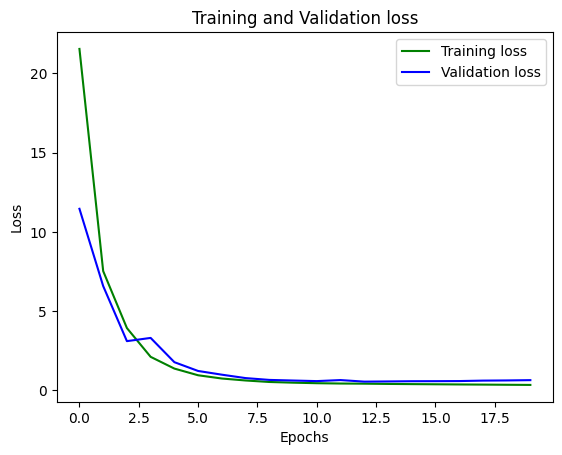

In [40]:
%matplotlib inline
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

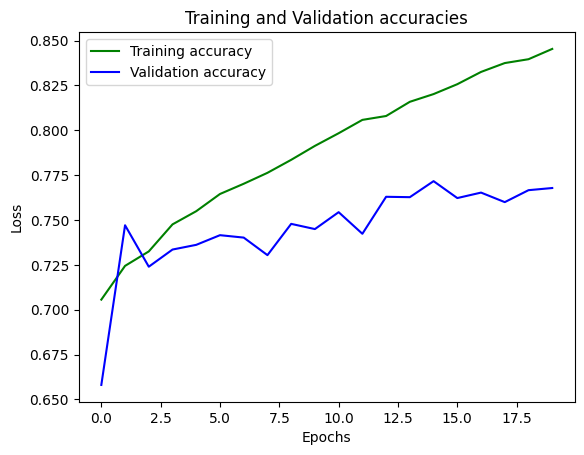

In [41]:
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
def compute_confusion_matrix(predictions: List[int], labels:List[int]) -> Tuple[int]:
    """
    Compute the confusion matrix.
    Arguments:
        predictions: list of model predictions (0 for cats or 1 for dogs)
        labels: list of ground truth labels (0 or 1)
    """
    correct_cats = 0
    correct_dogs = 0
    wrong_cats = 0
    wrong_dogs = 0
    for (p,l) in zip(predictions, labels):
        if p == 0 and l == 0:
            correct_cats += 1
        elif p == 0 and l == 1:
            wrong_cats += 1
        elif p == 1 and l == 1:
            correct_dogs += 1
        else:
            wrong_dogs += 1

    return (correct_cats, wrong_cats, correct_dogs, wrong_dogs)

In [43]:
def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns:
     - the epoch validation loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels
    """
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for batch_titles, batch_content, batch_labels in tqdm(val_dataloader):
            batch_labels = batch_labels \
                  .type(torch.FloatTensor) \
                  .reshape((batch_labels.shape[0], 1))
            batch_labels = batch_labels.to(device)

            to_use = batch_titles

            mask = to_use['attention_mask'].to(device)
            input_id = to_use['input_ids'].squeeze(1).to(device)
            # batch_size x 10
            # feedforward
            out = model(input_id)
            probabilities = torch.sigmoid(out.squeeze())  # Apply sigmoid activation
            batch_predictions = (probabilities >= 0.5).long()

            predictions += batch_predictions.squeeze().tolist()
            labels += batch_labels.squeeze().tolist()

            loss = loss_crt(out, batch_labels)
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

In [ ]:
fin_loss, preds, labels = eval_epoch(
    model, val_dataloader, loss_crt, device)

90it [00:00, 1288.09it/s]


In [ ]:
len(preds)

714

100%|██████████| 221/221 [00:00<00:00, 253.50it/s]


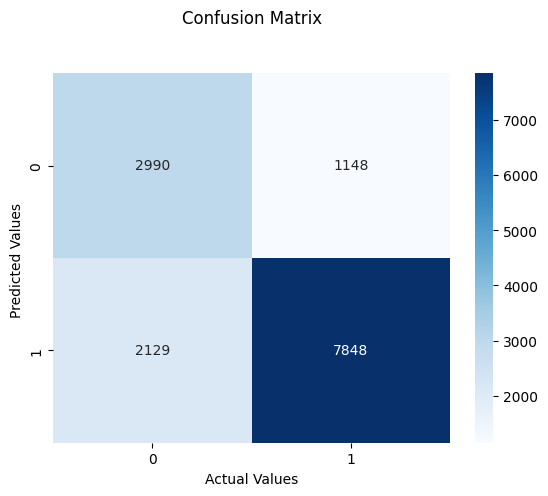

In [44]:
fin_loss, preds, labels = eval_epoch(
    model, val_dataloader, loss_crt, device)


correct_cats, wrong_cats, correct_dogs, wrong_dogs = compute_confusion_matrix(
    preds,
    labels
)
cf_matrix = [
    [correct_cats, wrong_cats],
    [wrong_dogs, correct_dogs]
]
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [50]:
f1_score(labels, preds)

0.8272808728192694

In [48]:
recall_score(labels, preds, average='macro')

0.7282430923044437

In [49]:
precision_score(labels, preds, average='macro')

0.7545902458205831

In [ ]:
len(preds)

180

In [ ]:
model1 = model

In [ ]:
fin_loss, val_predictions, val_labels = eval_epoch(
    model1, val_dataloader, loss_crt, device)

45it [00:00, 957.53it/s]


In [ ]:
model2 = model ##### overfit nebun, 512, 1024, 1025 ---//----

In [ ]:
model3 = model ###### 12 epoci, 256, 256, 256,      ...... , 20 376....

In [ ]:
print(torch.bincount(y_train))

tensor([2696,  156])


In [45]:
model1Bun = model ### Platou 76 - titlu, 526, 128, 4, cu weight 3, 20 epoci

In [51]:

test_data = pd.read_csv('/content/drive/MyDrive/NLP3/test.csv')
test_data['class'] = [True for _ in range(len(test_data['title']))]
print(test_data.head())
# print(df_test.head())


print(len(test_data))
X = []
y = []

for i, row in test_data.iterrows():
  X.append([row['title'], row['content']])
  if(row['class'] == True):
    y.append(1)
  elif (row['class'] == False):
    y.append(0)


test_fin = {}
test_fin['title'] = []
test_fin['content'] = []
test_fin['class'] = []

for i in range(len(X)):
  test_fin['title'].append(X_train[i][0])
  test_fin['content'].append(X_train[i][1])
  test_fin['class'].append(y_train[i])



   id                                              title  \
0   0  Financial Times: SUA, Japonia, Australia și In...   
1   1  Guvernul poate muta Ziua Culturii Române de pe...   
2   2  Ministrul ucrainean al Apărării susține că au ...   
3   3  Amantul unei angajate ANAF s-a sinucis, nemais...   
4   4  Boloş: Nu este vorba de o taxă nouă pe concedi...   

                                             content  class  
0  SUA, Japonia, Australia și India vor dezvălui ...   True  
1  Guvernul ia în considerare să mute Ziua Cultur...   True  
2  Aleksei Reznikov a afirmat în cadrul unui mesa...   True  
3  Poliția anchetează cazul unei morți suspecte a...   True  
4  „Ca ministru al Finanţelor, este important să ...   True  
36669


In [57]:
from sklearn.metrics import balanced_accuracy_score

def balanced_accuracy_evaluate(model, test_data):
    final_ans = []


    fin_loss, preds, labels = eval_epoch(
    model, test_dataloader, loss_crt, device)
    return preds, labels

In [58]:
test = Dataset(test_fin)

test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)

In [60]:

predict, labels = balanced_accuracy_evaluate(model, test_fin)

print(len(predict))


100%|██████████| 573/573 [00:05<00:00, 104.47it/s]

36669


In [62]:
def code_to_text(code):
  labels = [False, True]
  return labels[code]

In [64]:
y_pred = []
output = predict
for i in range(len(output)):
  try:
    item0, item1 = output[i]
    y_pred.extend([code_to_text(item0), code_to_text(item1)])
  except:
    item0 = output[i]
    y_pred.append(code_to_text(item0))
predict = y_pred

In [66]:
predict

[True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True

In [67]:
i = range(len(predict))
dict = {'id':i, 'class':predict}

final = pd.DataFrame(dict)

fc = final.columns[0]
final = final.drop([fc], axis=1)
# final.columns = ['Id', 'Label']
final.to_csv('final.csv')